# 🍎 Apples counting 🍎


The goal of this tiny project is to count the number of red apples present in this image
<div style="text-align: left;">
    <img src="apples.png" alt="Description of your image" width=400, height=300>
</div>

However, as we can see, the background is textured (striped) which makes the task more complicated 🤨


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
image = cv2.imread("apples.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

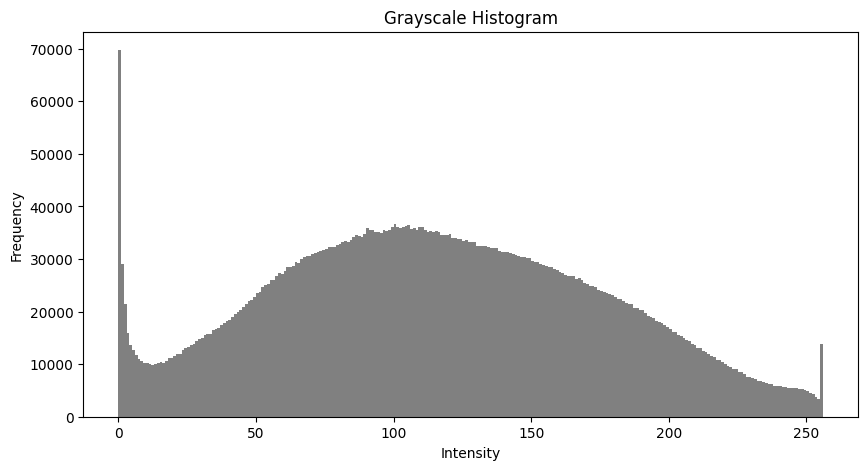

In [4]:
# plot the grayscale histogram
plt.figure(figsize=(10, 5))
plt.hist(image_rgb.flatten(), 256, [0, 256], color="gray")
plt.title("Grayscale Histogram")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()

In [5]:
image = cv2.imread("apples.png", cv2.IMREAD_GRAYSCALE)
# mean intensity
mean_intensity = np.mean(image)
# standard deviation of the intensity of gray pixels
contrast = np.sqrt(
    np.sum((image - mean_intensity) ** 2) / (image.shape[0] * image.shape[1])
)
print(f"Apples image contrast: {round(contrast,2)}")

Apples image contrast: 51.23


As we can obsesrve, there isn't much contrast in this image

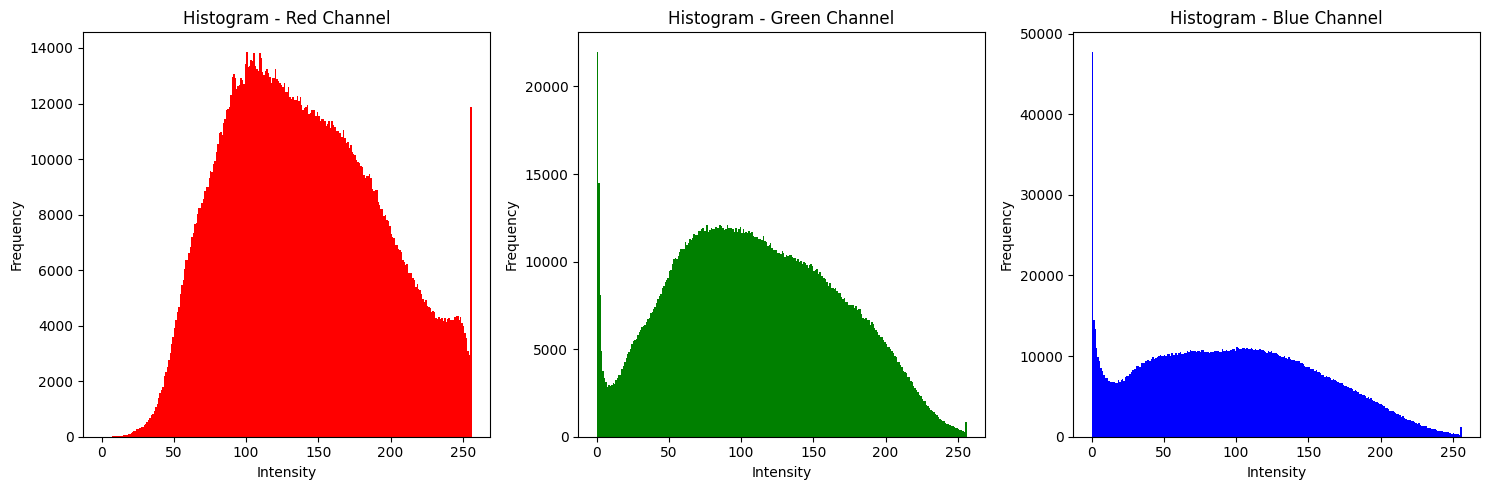

In [6]:
# plot the hist for the 3 color channels
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
# red channel
axes[0].hist(image_rgb[:, :, 0].flatten(), 256, [0, 256], color="red")
axes[0].set_title("Histogram - Red Channel")
axes[0].set_xlabel("Intensity")
axes[0].set_ylabel("Frequency")
# green channel
axes[1].hist(image_rgb[:, :, 1].flatten(), 256, [0, 256], color="green")
axes[1].set_title("Histogram - Green Channel")
axes[1].set_xlabel("Intensity")
axes[1].set_ylabel("Frequency")
# blue channel
axes[2].hist(image_rgb[:, :, 2].flatten(), 256, [0, 256], color="blue")
axes[2].set_title("Histogram - Blue Channel")
axes[2].set_xlabel("Intensity")
axes[2].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### HSV Conversion
We convert the image to HSV color space  which is often preferred for color-based segmentation tasks because it separates color information (hue) from intensity (value) and saturation. This separation makes it easier to define and detect specific colors regardless of their intensity or brightness.

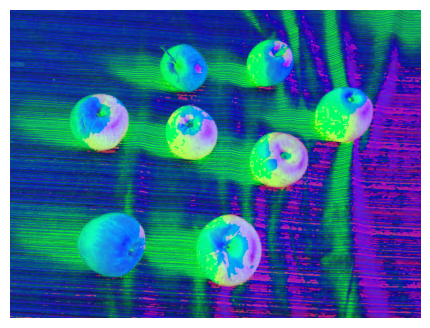

In [7]:
# conversion to hsv space
og_img = cv2.imread("apples.png")
hsv = cv2.cvtColor(og_img, cv2.COLOR_BGR2HSV)
plt.figure(figsize=(6, 4))
plt.axis("off")
plt.imshow(hsv)
plt.show()

### Bounds definition
Then, we define the lower and upper color bounds. In color segmentation, lower and upper bounds define a range of color values that correspond to the specific color we want to isolate in the image, in our case it is red.

In [8]:
# defining the red bounds
# (hue, satuation, value)
# lower_red = np.array([0, 100, 100])
# upper_red = np.array([10, 255, 255])

# -------- after experimenting --------
# lower_red = np.array([0, 150, 100])
# upper_red = np.array([20, 255, 255])


### Mask creation
A mask isolates specific parts of an image based on color, allowing us to perform further operations on the isolated parts only, in our case, it's the red apples we want to separate from the textured striped background then count them.

In [9]:
# after further experimentation
lower_red1 = np.array([0, 100, 100])
upper_red1 = np.array([10, 255, 255])

# Additional HSV bounds for red apples
lower_red2 = np.array([170, 70, 50])
upper_red2 = np.array([180, 255, 255])
# Create binary masks for both HSV ranges
mask_red1 = cv2.inRange(hsv, lower_red1, upper_red1)
mask_red2 = cv2.inRange(hsv, lower_red2, upper_red2)

After further experimentation, we used a combined mask to improve the segmentation of red apples by capturing the full range of red hues that can appear in the image

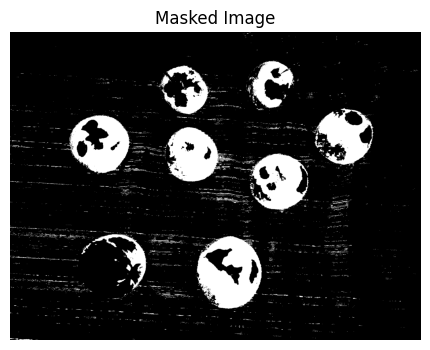

In [10]:
# Mask for red color
# using a combined mask
combined_mask = cv2.bitwise_or(mask_red1, mask_red2)
plt.figure(figsize=(6, 4))
plt.title("Masked Image")
plt.axis("off")
plt.imshow(combined_mask, cmap="gray")
plt.show()

We notice that there is still some noise in the background, the masked image needs further processing, let's experiment with **morphological transformations**.

### Morphological operations (Opening and closing)
In order to further prepare the image for the next phase which is object counting, there are additional operation to perform to reduce the noise. 

Here we perform **opening** which helps to remove noise from the binary mask and enhance object segmentation while preserving the shape and size of the objects of interest , basically opening is just another name of erosion followed by dilation. It is useful in removing noise.
Addiotnaly, we also perfomr **closing** which is the reverse of Opening, Dilation followed by Erosion. It is useful in closing small holes inside the foreground objects, or small black points on the object.

With the choice of an appropriate kernel size (in this case, a 5x5 square kernel)

#### Side note :
- **Erosion** : The basic idea of erosion is just like soil erosion only, it erodes away the boundaries of foreground object (Always try to keep foreground in white)The kernel slides through the image (as in 2D convolution). A pixel in the original image (either 1 or 0) will be considered 1 only if all the pixels under the kernel is 1, otherwise it is eroded (made to zero), so all the pixels near boundary will be discarded depending upon the size of kernel. So the thickness or size of the foreground object decreases or simply white region decreases in the image. It is useful for removing small white noises (as we have seen in colorspace chapter), detach two connected objects etc.
- **Dilation** : It is just opposite of erosion. Here, a pixel element is '1' if at least one pixel under the kernel is '1'. So it increases the white region in the image or size of foreground object increases. Normally, in cases like noise removal, erosion is followed by dilation. Because, erosion removes white noises, but it also shrinks our object. So we dilate it. Since noise is gone, they won't come back, but our object area increases. It is also useful in joining broken parts of an object.


**Source** : [OpenCV Documentation](https://docs.opencv.org/4.x/d9/d61/tutorial_py_morphological_ops.html)

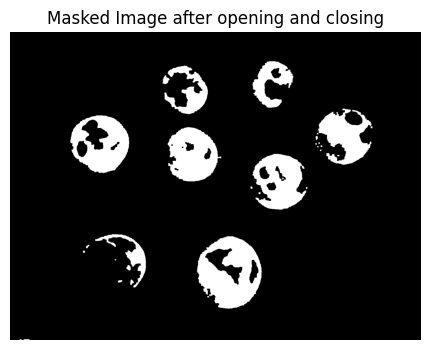

In [11]:
# applying morphological operations to remove noise
kernel = np.ones((5, 5), np.uint8)
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
combined_mask = cv2.morphologyEx(combined_mask, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(6, 4))
plt.title("Masked Image after opening and closing")
plt.axis("off")
plt.imshow(combined_mask, cmap="gray")
plt.show()

### Applying contour detection
- Contours are outlines of the shapes in the image. we will perform contour detection on the masked image shown above.
- We use `cv2.RETR_EXTERNAL` to retrieve to specify that we will retrieve the external contours and ignores contours inside the shape. 
- `cv2.CHAIN_APPROX_SIMPLE` specifies that the contour approximation method, in this case, we will use the simple approximation which compresses horizontal, vertical, and diagonal segments and leaves only their end points. For example, if we have a straight line, it will just store the two end points of that line.
- The function `cv2.findContours`return the following parameters 
    -  Contours: This is a Python list of all the contours found in the image. Each contour is represented as a numpy array of (x, y) coordinates of boundary points of the object.

    -  Hierarchy: This is an optional output parameter that provides information about the hierarchical relationships between contours. 

In [12]:
# Find contours
contours, _ = cv2.findContours(
    combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
)
print(f"The number of contours : {len(contours)}")

The number of contours : 29


In [13]:
for contour in contours:
    print(contour.shape)

(4, 1, 2)
(4, 1, 2)
(4, 1, 2)
(16, 1, 2)
(20, 1, 2)
(25, 1, 2)
(4, 1, 2)
(8, 1, 2)
(18, 1, 2)
(401, 1, 2)
(386, 1, 2)
(4, 1, 2)
(7, 1, 2)
(10, 1, 2)
(4, 1, 2)
(403, 1, 2)
(4, 1, 2)
(4, 1, 2)
(6, 1, 2)
(4, 1, 2)
(4, 1, 2)
(9, 1, 2)
(4, 1, 2)
(289, 1, 2)
(348, 1, 2)
(545, 1, 2)
(51, 1, 2)
(447, 1, 2)
(313, 1, 2)


The  shape of contours coordinates : (n, 1, 2) which means that:
- n : is the number of points that make up the contour 
- 1: Each point is represented as a 1x2 array (an array with two elements)
- 2: Each point consists of two values, typically the (x, y) coordinates of the contour point.

### Filter and approximate contours : 
- `min_area` : This threshold value determines the minimum area that a contour must have to be considered significant. Contours with areas less than 1000 pixel units will be filtered out
- We iterate over the 4 detected contours and for each one, we calclate is area and see if it is over or under the min_area
- If the area of the current contour is greater than min_area, the contour is considered significant and is further processed.
- `cv2.approxPolyDP(contour, epsilon, closed` approximates the contour to reduce the number of points needed to represent it while retaining its shape. It approximates a polygonal curve with the specified approximation accuracy (epsilon). Larger values of epsilon lead to more approximation. Here, epsilon is set to 2% ( then 0.5 % after experimentation) of the contour's arc length. This parameter controls how closely the approximated contour follows the original contour. 'True' indicates that the contour is closed (i.e., the first and last vertices are connected

In [14]:
# to store the filtered contours
red_apples_contours = []
min_area = 1000
for i, contour in enumerate(contours, 1):
    area = cv2.contourArea(contour)
    print(f"Contour {i} -> Contour area: {area}")
    if area > min_area:
        # approximating the contours to reduce nb of points
        approx = cv2.approxPolyDP(contour, 0.005 * cv2.arcLength(contour, True), True)
        red_apples_contours.append(approx)

Contour 1 -> Contour area: 44.0
Contour 2 -> Contour area: 12.0
Contour 3 -> Contour area: 24.0
Contour 4 -> Contour area: 104.5
Contour 5 -> Contour area: 162.5
Contour 6 -> Contour area: 226.0
Contour 7 -> Contour area: 16.0
Contour 8 -> Contour area: 46.5
Contour 9 -> Contour area: 80.0
Contour 10 -> Contour area: 52264.5
Contour 11 -> Contour area: 7415.0
Contour 12 -> Contour area: 42.0
Contour 13 -> Contour area: 28.0
Contour 14 -> Contour area: 49.0
Contour 15 -> Contour area: 28.0
Contour 16 -> Contour area: 31695.0
Contour 17 -> Contour area: 20.0
Contour 18 -> Contour area: 16.0
Contour 19 -> Contour area: 29.0
Contour 20 -> Contour area: 20.0
Contour 21 -> Contour area: 20.0
Contour 22 -> Contour area: 80.0
Contour 23 -> Contour area: 20.0
Contour 24 -> Contour area: 31531.5
Contour 25 -> Contour area: 38650.5
Contour 26 -> Contour area: 23746.0
Contour 27 -> Contour area: 530.0
Contour 28 -> Contour area: 12304.5
Contour 29 -> Contour area: 14054.5


### Visualizing the contoured image and counting the apples

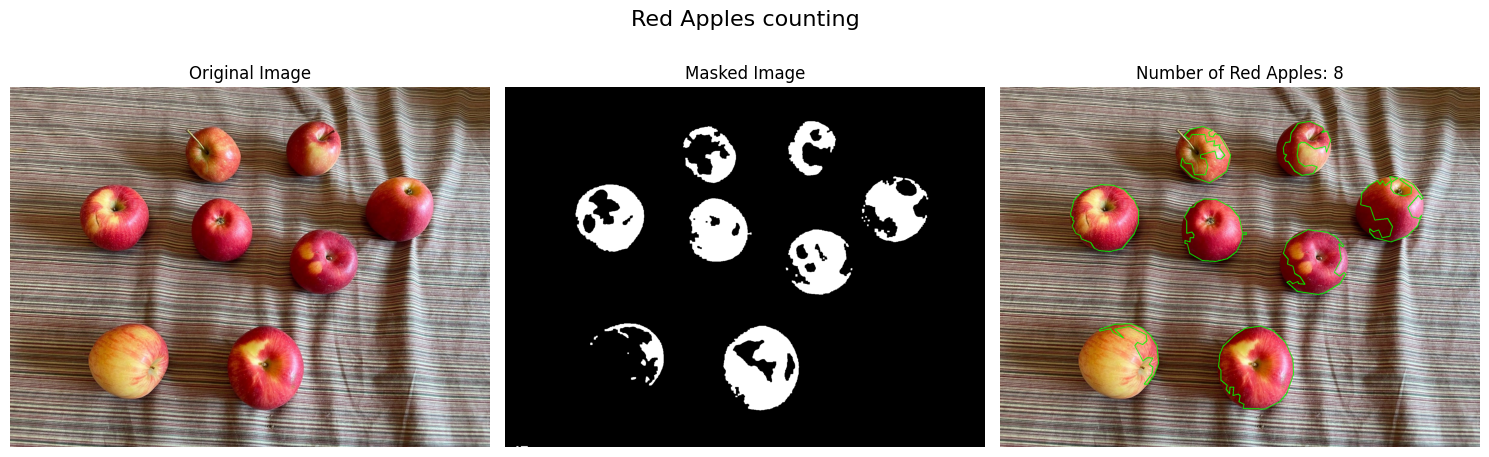

In [15]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Red Apples counting", fontsize=16)
image = cv2.imread("apples.png", cv2.COLOR_BGR2RGB)

# Plot 1: the original image
axes[0].imshow(image_rgb)
axes[0].axis("off")
axes[0].set_title("Original Image")

# Plot 2: the masked img
axes[1].imshow(combined_mask, cmap="gray")
axes[1].axis("off")
axes[1].set_title("Masked Image")

# Plot 3: Image with Contours
image_with_contours = image.copy()
# -1 to draw all the contours in green with thickness of 2 pixels
cv2.drawContours(
    image=image_with_contours,
    contours=red_apples_contours,
    contourIdx=-1,
    color=(0, 255, 0),
    thickness=2,
)
axes[2].imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
axes[2].axis("off")
axes[2].set_title(f"Number of Red Apples: {len(red_apples_contours)}")

plt.tight_layout()
plt.show()

## In total, we have 8 apples 🍎